In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor
from torchvision import models,transforms

from typing import Tuple, Optional, Callable

from utils import mask_circuit, device, sorted_df_list, sorted_df_dict, tensor_to_img, imgs_df
from class_info import *

In [2]:
class_transform = transforms.Compose([
            transforms.Resize(size=(256, 256)),
            transforms.ToTensor(),  # Convert to PyTorch Tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

segment_transform = transforms.Compose([
            transforms.Resize(size=(256, 256)),
            transforms.ToTensor(),  # Convert to PyTorch Tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [3]:
class FinalProject():
    """
    Класс для комплексной обработки изображений (классификация + сегментация)
    
    Атрибуты:
        classification_model (str): Путь к модели классификации
        segmentation_model (str): Путь к модели сегментации
        threshold (float): Порог бинаризации для маски сегментации
    """
    classification_model: str = 'full_model_mobilevitv2.pth'
    segmentation_model: str = 'full_unet.pth'
    threshold: bool = 0.5
    
    def __init__(
        self,  
        img: Image.Image,
        class_transform: transforms.Compose,
        segment_transform: transforms.Compose,
        return_transform: bool = False,):
        """
        Инициализация обработчика изображений
        
        Параметры:
            img (PIL.Image): Входное изображение
            class_transform (transforms.Compose): Трансформы для классификации
            segment_transform (transforms.Compose): Трансформы для сегментации
            return_transform (bool): Флаг возврата к исходному размеру
            info_list (list): Список описаний классов для вывода
        """
        self.img = img
        self.class_transform = class_transform
        self.segment_transform = segment_transform
        self.return_transform = return_transform

    def analiz(self):
        """
        Основной метод анализа изображения
        
        Возвращает:
            tuple: (текстовое описание класса(info_list[img_pred]), изображение с контуром сегментации(функция mask_circuit(()))
            
        """
        class_mod = torch.load(self.classification_model, weights_only=False)
        seq_model = torch.load(self.segmentation_model, weights_only=False)

        img_class = self.class_transform(self.img).cuda()
        class_mod.eval()
        with torch.no_grad():
            class_out = class_mod(img_class.unsqueeze(0))
            img_pred = class_out.max(1, keepdim=True)[1].item()

        img_seg = self.segment_transform(self.img).cuda()
        seq_model.eval()
        with torch.no_grad():
            seq_out = seq_model(img_seg.unsqueeze(0))
            seq_pred = (seq_out > self.threshold).float()

        print(info_list[img_pred])
        if self.return_transform:
            return mask_circuit(transforms.Resize(size=(self.img.size[::-1]))(img_seg), transforms.Resize(size=(self.img.size[::-1]))(seq_pred), True, True) # возвращаем размерность к исходной
        else:
            return mask_circuit(img_seg, seq_pred, True, True) # не возвращаем размерность к исходной

In [63]:
test_df = pd.read_csv('test_df.csv')
# test_df['dx'].value_counts()

Melanocytic nevi


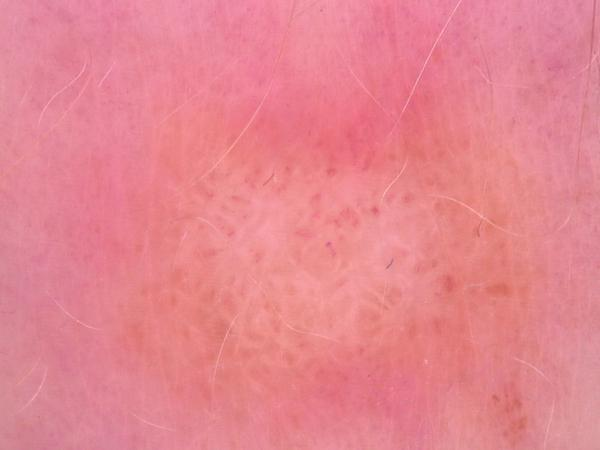

In [164]:
# вбираем рандомное изображение
random_img = np.random.randint(len(test_df))
imgs_df['image_id'][random_img]
directory = 'C:/Users/Igor/Desktop/Project_DS50/data/imgs/' + imgs_df['image_id'][random_img] + '.jpg'
img = Image.open(directory).convert("RGB")
print(imgs_df['full_cell_type_name'][random_img])
img


Melanocytic Nevi 
Меланоцитарные невусы — это доброкачественные образования на коже, которые чаще всего известны как родинки. 
Они состоят из скоплений меланоцитов — клеток, вырабатывающих пигмент меланин, который придает коже, волосам и глазам их цвет.

Характеристики:
    • Внешний вид: Могут быть плоскими или выпуклыми.
    • Цвет: Обычно коричневый, но может варьироваться от светло-коричневого до черного.
    • Размер: От нескольких миллиметров до нескольких сантиметров.
    • Форма: Обычно круглая или овальная.
    • Локализация: Любые участки кожи.

Риск:
    • Генетическая предрасположенность: Наличие родинок может быть связано с наследственностью.
    • Воздействие ультрафиолетового излучения: Солнечные лучи могут стимулировать появление новых родинок.
    • Гормональные изменения: Например, во время беременности или полового созревания.

Лечение:
    Обычно лечение не требуется:
        o Большинство невусов являются доброкачественными и не требуют лечения.
    Удаление:
    

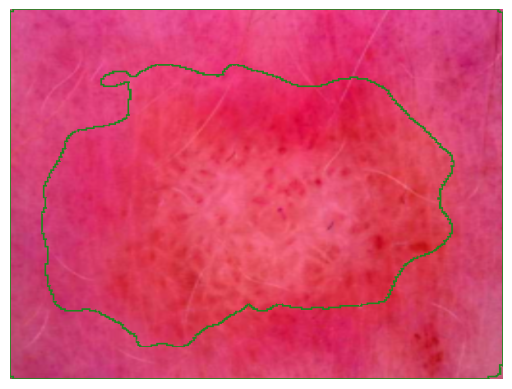

In [165]:
try_1 = FinalProject(img, class_transform, segment_transform, True)
try_1.analiz()